In [1]:
!nvidia-smi
from google.colab import files
files.upload()

!pip install --ignore-installed --upgrade kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c petfinder-pawpularity-score
!unzip petfinder-pawpularity-score.zip
!kaggle datasets download -d mithilsalunkhe/no-dupes-rice-fold
!unzip no-dupes-rice-fold.zip
!kaggle datasets download -d phalanx/petfinder2-cropped-dataset
!unzip petfinder2-cropped-dataset.zip
!kaggle datasets download -d mithilsalunkhe/pseudo-with-old-comp
!mkdir pseudo
!unzip /content/pseudo-with-old-comp.zip -d pseudo

!pip install -qq timm
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir -qqq

!pip uninstall opencv_python_headless

!pip install opencv-python-headless==4.5.4.60
!pip install -qq albumentations==1.0.3
!pip install -qq grad-cam
!pip install -qq ttach
!pip install -qq scikit-learn==0.24.0
!pip install -qq fastai
!pip install -qq fastai --upgrade

Mon Jan  3 04:43:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Saving kaggle.json to kaggle.json
     |████████████████████████████████| 58 kB 5.8 MB/s 
     |████████████████████████████████| 149 kB 32.9 MB/s 
     |████████████████████████████████| 247 kB 61.0 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 76 kB 6.1 MB/s 
     |████████████████████████████████| 138 kB 73.3 MB/s 
     |████████████████████████████████| 78 kB 9.1 MB/s 
     |████████████████████████████████| 61 kB 10.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=a20bd10d6425bda735dc2a75ce136d0eef4c82188a800b7b06fc968679fe2bc0
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but yo

Streaming output truncated to the last 5000 lines.
  inflating: pseudo/c0270a5f1-1.jpg  
  inflating: pseudo/c02ce1bc0-3.jpg  
  inflating: pseudo/c02ce1bc0-4.jpg  
  inflating: pseudo/c02ce1bc0-6.jpg  
  inflating: pseudo/c03fe7452-1.jpg  
  inflating: pseudo/c042fa2d5-2.jpg  
  inflating: pseudo/c042fa2d5-5.jpg  
  inflating: pseudo/c0488da92-1.jpg  
  inflating: pseudo/c04cf0018-1.jpg  
  inflating: pseudo/c0503dd75-1.jpg  
  inflating: pseudo/c0503dd75-2.jpg  
  inflating: pseudo/c0503dd75-3.jpg  
  inflating: pseudo/c053ae854-1.jpg  
  inflating: pseudo/c05a85bbb-1.jpg  
  inflating: pseudo/c05a85bbb-2.jpg  
  inflating: pseudo/c05a85bbb-4.jpg  
  inflating: pseudo/c05adb8fe-1.jpg  
  inflating: pseudo/c05b7439a-4.jpg  
  inflating: pseudo/c05b7439a-5.jpg  
  inflating: pseudo/c05b74b05-1.jpg  
  inflating: pseudo/c0677007e-3.jpg  
  inflating: pseudo/c0677007e-5.jpg  
  inflating: pseudo/c0677007e-7.jpg  
  inflating: pseudo/c0677007e-8.jpg  
  inflating: pseudo/c0771fde0-2.jpg  

In [5]:
!unzip no-dupes-rice-fold.zip


Archive:  no-dupes-rice-fold.zip
replace train_10folds.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_10folds.csv       
replace train_5folds.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_5folds.csv        


In [3]:
import sys
from timm import create_model
from timm.data.mixup import Mixup

from fastai.vision.all import *
#from fastai.callback.hook import *

In [4]:
set_seed(365, reproducible=True)
BATCH_SIZE = 8
NEED_TRAIN = True

In [5]:
"""clean_dataset_path = Path('../input/petfinder-pawpularity-score-clean/')
clean_dataset_path.ls()

dataset_path = Path('../input/petfinder-pawpularity-score/')
dataset_path.ls()

train_df = pd.read_csv(clean_dataset_path/'train.csv')

train_df['path'] = train_df['Id'].map(lambda x:str(clean_dataset_path/'train'/x)+'.jpg')"""
train_df = pd.read_csv('/content/train_10folds.csv')
dataset_path = Path('/content/train')
train_df['path'] = train_df['Id'].map(lambda x: str(dataset_path/x) + '.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,Breed,kfold,path
0,0,1,1,1,0,0,0,0,0,0,0,0,25,1,8,/content/train/7b4c408fa4ad8bc1d1a720dc0417c8b6.jpg
1,0,1,1,1,0,0,0,0,0,0,0,0,36,0,2,/content/train/b9cf47f8b3b5a0855bb3293b138776e5.jpg
2,0,1,1,0,0,0,0,0,1,1,0,0,51,1,8,/content/train/ff903858a9899465ee4cd17e942bef24.jpg
3,1,1,1,1,0,0,0,0,0,0,0,0,29,1,5,/content/train/86ccbbb4eee306d37ac4c41c031ffce5.jpg
4,0,1,1,1,0,0,0,0,0,0,0,0,17,0,0,/content/train/fe80fffa8bab0dafba63a9b4f07b557a.jpg


There are 9885 images
The mean Pawpularity score is 38.049974709155286
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.599054723289747
There are 100 unique values of Pawpularity score


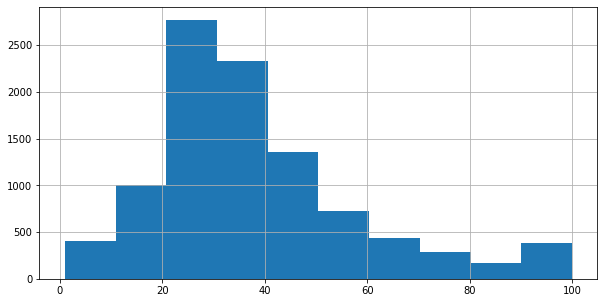

In [6]:
len_df = len(train_df)
print(f"There are {len_df} images")

train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")

print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")

In [7]:
train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']


0       0.25
1       0.36
2       0.51
3       0.29
4       0.17
        ... 
9880    0.54
9881    0.27
9882    0.42
9883    0.76
9884    0.30
Name: norm_score, Length: 9885, dtype: float64

In [8]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

cp: cannot stat '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth': No such file or directory


In [9]:
seed=365
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [10]:
"""#Sturges' rule
num_bins = int(np.floor(1+np.log2(len(train_df))))
num_bins

train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

#from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1


N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

train_df[train_df['fold']==0].head()

train_df[train_df['fold']==0]['bins'].value_counts()

train_df[train_df['fold']==1]['bins'].value_counts()"""

"#Sturges' rule\nnum_bins = int(np.floor(1+np.log2(len(train_df))))\nnum_bins\n\ntrain_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)\ntrain_df['bins'].hist()\n\n#from sklearn.model_selection import KFold\nfrom sklearn.model_selection import StratifiedKFold\n\ntrain_df['fold'] = -1\n\n\nN_FOLDS = 10\nstrat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)\nfor i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):\n    train_df.iloc[train_index, -1] = i\n    \ntrain_df['fold'] = train_df['fold'].astype('int')\n\ntrain_df.fold.value_counts().plot.bar()\n\ntrain_df[train_df['fold']==0].head()\n\ntrain_df[train_df['fold']==0]['bins'].value_counts()\n\ntrain_df[train_df['fold']==1]['bins'].value_counts()"

In [11]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [12]:
def get_data(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['kfold'] == fold)
    
    #mixup_fn = Mixup(**mixup_args)
    
#     dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
# #                                valid_pct=0.2, #80-20 train-validation random split
#                                valid_col='is_valid', #
#                                seed=999, #seed
#                                fn_col='path', #filename/path is in the second column of the DataFrame
#                                label_col='norm_score', #label is in the first column of the DataFrame
#                                y_block=RegressionBlock, #The type of target
#                                bs=BATCH_SIZE, #pass in batch size
#                                num_workers=8,
#                                item_tfms=Resize(224), #pass in item_tfms
#                                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    # It looks if seed of RandomSplitter is set, it reduce the score. So we don't set seed here
    #splitter = RandomSplitter(0.2)
    # Change RandomSplitter to IndexSplitter
    #splitter = IndexSplitter(splitter(range(len(train_df)))[1])
    val_idx = train_df_f[train_df_f['is_valid']].index.values
    
    dls = DataBlock(blocks=(ImageBlock, RegressionBlock),
                get_x=ColReader('path'),
                get_y=ColReader('norm_score'  ),
                splitter=IndexSplitter(val_idx),
                item_tfms=Resize(224), #pass in item_tfms
                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation(), Flip(), Rotate(max_deg=45)])
               )
    
    paw_dls = dls.dataloaders(train_df_f, 
                          bs=BATCH_SIZE,
                          num_workers=8,
                          seed=seed)
    
    return paw_dls#, splitter


In [13]:
"""mixup_args = {
             'mixup_alpha': 1.,
             'cutmix_alpha': 0.,
             'cutmix_minmax': None,
             'prob': 1.0,
             'switch_prob': 0.,
             'mode': 'batch',
             'label_smoothing': 0,
             'num_classes': 1}"""

"mixup_args = {\n             'mixup_alpha': 1.,\n             'cutmix_alpha': 0.,\n             'cutmix_minmax': None,\n             'prob': 1.0,\n             'switch_prob': 0.,\n             'mode': 'batch',\n             'label_smoothing': 0,\n             'num_classes': 1}"

In [14]:
def get_learner(fold_num):
    data = get_data(fold_num)
    
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(petfinder_rmse), cbs=[MixUp(0.4)]).to_fp16()
    
    return learn #, splitter

Fold 0 results


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.652510,0.645162,18.219957,08:30
1,0.647655,0.642755,17.933910,08:30
2,0.651166,0.639416,17.472626,08:32
3,0.642963,0.637282,17.202518,08:31
4,0.639399,0.637809,17.288525,08:31


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6451618075370789.
Better model found at epoch 1 with valid_loss value: 0.6427549719810486.
Better model found at epoch 2 with valid_loss value: 0.6394157409667969.
Better model found at epoch 3 with valid_loss value: 0.6372818946838379.


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Pawpularity vs OOF
4     17
6     20
10    28
19    43
21    32
Name: Pawpularity, dtype: int64 [[23.100916]
 [34.01718 ]
 [36.932663]
 [37.5975  ]
 [46.3395  ]]
Fold 0 RMSE: 17.201838685720336
Fold 1 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.655978,0.646880,18.463070,08:32
1,0.652700,0.649645,18.748665,08:32
2,0.641969,0.645238,18.257935,08:31
3,0.648253,0.643488,17.999235,08:31
4,0.638762,0.643808,18.023529,08:31


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6468797922134399.
Better model found at epoch 2 with valid_loss value: 0.6452378034591675.
Better model found at epoch 3 with valid_loss value: 0.6434882283210754.


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Pawpularity vs OOF
7     63
11    67
18    39
20    36
31    29
Name: Pawpularity, dtype: int64 [[42.140884]
 [53.53948 ]
 [35.702625]
 [24.250734]
 [47.558483]]
Fold 1 RMSE: 17.99896233104272
Fold 2 results


epoch,train_loss,valid_loss,petfinder_rmse,time


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.655510,0.646073,18.412020,08:31
1,0.646312,0.642725,17.966812,08:33
2,0.636754,0.641109,17.741226,08:34
3,0.643724,0.638693,17.447973,08:33
4,0.638069,0.639104,17.497774,08:32


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6460734605789185.
Better model found at epoch 1 with valid_loss value: 0.6427252292633057.
Better model found at epoch 2 with valid_loss value: 0.6411088109016418.
Better model found at epoch 3 with valid_loss value: 0.6386927962303162.


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Pawpularity vs OOF
1     36
68    30
69    20
70    24
80    25
Name: Pawpularity, dtype: int64 [[34.59947 ]
 [32.17221 ]
 [23.884552]
 [37.116505]
 [24.45035 ]]
Fold 2 RMSE: 17.447586215112114
Fold 3 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.656996,0.648148,18.723129,08:33
1,0.650264,0.645371,18.378977,08:33
2,0.641811,0.645143,18.353170,08:33
3,0.642047,0.642763,18.030750,08:33
4,0.636117,0.643091,18.064016,08:33


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6481478810310364.
Better model found at epoch 1 with valid_loss value: 0.6453714966773987.
Better model found at epoch 2 with valid_loss value: 0.6451425552368164.
Better model found at epoch 3 with valid_loss value: 0.6427633166313171.


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Pawpularity vs OOF
13    33
23    63
46    40
49     2
51    55
Name: Pawpularity, dtype: int64 [[30.984682]
 [48.534615]
 [27.02169 ]
 [27.281227]
 [48.640095]]
Fold 3 RMSE: 18.0300908465927
Fold 4 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.644945,0.649087,18.608587,08:33
1,0.654275,0.643010,17.886471,08:33
2,0.643843,0.643105,17.880930,08:32
3,0.641641,0.639640,17.423738,08:32
4,0.637842,0.639946,17.450514,08:32


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6490872502326965.
Better model found at epoch 1 with valid_loss value: 0.643009603023529.
Better model found at epoch 3 with valid_loss value: 0.639639675617218.


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Pawpularity vs OOF
15    23
26    41
38    26
58    27
73    44
Name: Pawpularity, dtype: int64 [[47.981922]
 [30.579525]
 [38.132866]
 [43.626698]
 [42.61712 ]]
Fold 4 RMSE: 17.421876355943947
Average Fold RMSE: 17.620070886882363


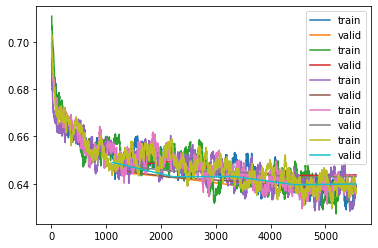

In [15]:
"""
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

if len(test_df) != 8:
    NEED_TRAIN = True"""

"""test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])"""
train_df['norm_score'] = train_df['Pawpularity']/100

import gc

from sklearn.metrics import mean_squared_error
folds = [0,1,2,3,4]
if NEED_TRAIN:
    rmse_list = []
    #train_df['oof'] = -1

    for i in folds:

        print(f'Fold {i} results')

        learn = get_learner(fold_num=i)
        
#         mixup_args = {
#             'mixup_alpha': 1.,
#             'cutmix_alpha': 0.,
#             'cutmix_minmax': None,
#             'prob': 1.0,
#             'switch_prob': 0.,
#             'mode': 'batch',
#             'label_smoothing': 0,
#             'num_classes': 100}
        
#         mixup_fn = Mixup(**mixup_args)

        learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 

        learn.recorder.plot_loss()
        
        #over fitting
#         learn.unfreeze()
        
#         learn.fit_one_cycle(5,lr_max=slice(1e-6,1e-4))

        learn = learn.to_fp32()

        learn.export(f'model_fold_{i}.pkl')
        
        #all_preds.append(preds)
        
        val_idx = train_df[train_df['kfold'] == i].index
        val_df = train_df.loc[val_idx]
        
        """dls = DataBlock(blocks=(ImageBlock, RegressionBlock),
                get_x=ColReader('path'),
                get_y=ColReader('norm_score'),
                #splitter=IndexSplitter(val_idx),
                item_tfms=Resize(224), #pass in item_tfms
                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation(), Flip(), Rotate(max_deg=45)])
               )
    
        paw_dls = dls.dataloaders(train_df, 
                          bs=BATCH_SIZE,
                          num_workers=8,
                          seed=seed)"""
        
        val_pred, _ = learn.get_preds()
        val_pred = val_pred.numpy()
        val_pred = val_pred * 100
        
        train_df.loc[val_idx, 'oof'] = val_pred
        print('Pawpularity vs OOF')
        print(val_df['Pawpularity'][:5], val_pred[:5])
        
        real_rmse = mean_squared_error(train_df[train_df['kfold'] == i]['Pawpularity'], 
                    train_df[train_df['kfold'] == i]['oof'], squared=False)
        
        fold_rmse = mean_squared_error(train_df[train_df['kfold'] == i]['oof'], train_df[train_df['kfold'] == i]['Pawpularity'], squared=False)
        print(f'Fold {i} RMSE: {fold_rmse}')
        rmse_list.append(fold_rmse)
        
        """
        #val_idx = splitter(range(len(train_df)))[1]
        train_df.loc[train_df[train_df['kfold'] == i].index, 'oof'] = oof_preds
        real_rmse = mean_squared_error(train_df[train_df['kfold'] == i]['Pawpularity'], 
                    train_df[train_df['kfold'] == i]['oof'], squared=False)
        rmse_list.append(real_rmse)
        print(f'real_rmse: {real_rmse:0.5f}')
        
        val_df = train_df.loc[val_idx]
        val_pred, _ = learn.tta(dl=paw_dls.test_dl(val_df), n=5, beta=0)
        print(val_df['Pawpularity'][:5], val_pred[:5])
        score = mean_squared_error(val_df['Pawpularity'], val_pred*100, squared=False)
        print(f'Fold {i} | Score: {score}')
        # Save prediction of validation as pred
        train_df.loc[val_idx, 'pred'] = val_pred*100"""

        del learn

        torch.cuda.empty_cache()

        gc.collect()

print(f'Average Fold RMSE: {sum(rmse_list) / len(rmse_list)}')

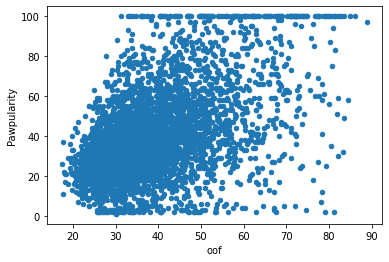

In [16]:
train_df[['oof','Pawpularity']].plot.scatter('oof','Pawpularity')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2efcb2f50>,
      dtype=object)

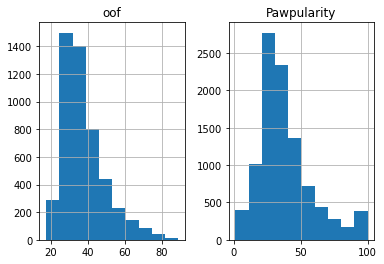

In [17]:
train_df[['oof','Pawpularity']].hist()

In [18]:
train_df.to_csv('train_with_oof.csv')

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
!cp -r /content/model_fold_0.pkl  /content/model_fold_1.pkl  /content/model_fold_2.pkl  /content/model_fold_3.pkl /content/model_fold_4.pkl /content/drive/MyDrive/models/Swinlarge224Fastai10kf